## Installing requirements



In [24]:
pip install python-dev-tools --user --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
conda install -c conda-forge hdbscan-with-cosine-distance


Note: you may need to restart the kernel to use updated packages.


'conda' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
pip install setuptools --upgrade --user

In [ ]:
pip install bertopic

## Import the words definition and required libraries

In [2]:
import pandas as pd
from bertopic import BERTopic

words = pd.read_csv("./resources/words.csv")
docs = words["Definitions"]

### Running experiments on combinations of algorithms

In [112]:
import numpy as np
from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.decomposition import PCA, TruncatedSVD
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, AgglomerativeClustering

embedding_models = ["all-mpnet-base-v2"]
mapping_methods_name = ["UMAP_euclidean"]
clustering_methods_name = ["HDBSCAN", "K_means_100", "Agglomerative_100"]
#Topic representation not tested yet

SEED = 100

mapping_methods = [UMAP(n_neighbors=15, n_components=50, min_dist=0.0, metric='euclidean'),]

clustering_methods = [
    HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
]
np.random.seed(SEED)

In [113]:
import itertools
for (embedding_model, mapping_methods_index, clustering_methods_index) in itertools.product(embedding_models, range(1), range(1)):
    print(f"Trial - Emdedding model: {embedding_model} - Mapping Method: {mapping_methods_name[mapping_methods_index]} - Clustering Method: {clustering_methods_name[clustering_methods_index]}")
    topic_model = BERTopic(hdbscan_model=clustering_methods[clustering_methods_index],
                           embedding_model=embedding_model,
                           umap_model=mapping_methods[mapping_methods_index])
    topics, probs = topic_model.fit_transform(docs)
    topic_model.get_document_info(docs).to_csv(f"./results_flatten_to_50/Topic_assignment_{embedding_model}_{mapping_methods_name[mapping_methods_index]}_{clustering_methods_name[clustering_methods_index]}.csv")
    

Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: UMAP_euclidean - Clustering Method: HDBSCAN


With the combination chosen, we run the model

In [14]:

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

sentence_model = SentenceTransformer("multi-qa-MiniLM-L6-dot-v1")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

topic_model = BERTopic(umap_model=, hdbscan_model= KMeans(n_clusters=100))
topics, probs = topic_model.fit_transform(docs, embeddings)


Visualize the topics selected by the model

In [110]:
topic_model.visualize_topics()

In [100]:

topic_model.visualize_heatmap()


In [114]:
import numpy as np
words_and_embedding = pd.read_csv("./results/words_and_embedding.csv", index_col="Unnamed: 0")
reduced_embeddings = np.array(words_and_embedding[["0", "1"]])
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

Save the results.

In [5]:
from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

sentence_model = SentenceTransformer("multi-qa-MiniLM-L6-dot-v1")
embeddings = sentence_model.encode(docs, show_progress_bar=False)
topic_model = BERTopic(umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='euclidean'), embedding_model=sentence_model)
topics, probs = topic_model.fit_transform(docs, embeddings)

In [6]:
topic_embeddings = topic_model.topic_embeddings_
docs_embeddings = topic_model._extract_embeddings(docs)


In [1]:
import pandas as pd
words = pd.read_csv("./resources/words.csv")
docs = words["Definitions"]

In [30]:
import numpy as np
from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.decomposition import PCA, TruncatedSVD
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, AgglomerativeClustering

embedding_models = ["multi-qa-MiniLM-L6-dot-v1"]
mapping_methods_name = ["PCA", "UMAP_euclidean", "Truncated_SVD"]
clustering_methods_name = ["HDBSCAN", "K_means_100", "Agglomerative_100"]
#Topic representation not tested yet

SEED = 100

mapping_methods = [PCA(n_components=5),
                   UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='euclidean'),
                   TruncatedSVD(n_components=5)]

clustering_methods = [
    HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    KMeans(n_clusters=100),
    AgglomerativeClustering(n_clusters=100)
]
np.random.seed(SEED)

results = pd.DataFrame({"Embedding model": [], "Mapping method" : [], "Clustering method": [], "Average distances to center": [], "Average for each clusters" : [], "Outlier": []})

import itertools
for (embedding_model, mapping_methods_index, clustering_methods_index) in itertools.product(embedding_models, range(3), range(3)):
    print(f"Trial - Emdedding model: {embedding_model} - Mapping Method: {mapping_methods_name[mapping_methods_index]} - Clustering Method: {clustering_methods_name[clustering_methods_index]}")
    sentence_model = SentenceTransformer(embedding_model)
    embeddings = sentence_model.encode(docs, show_progress_bar=False)

    topic_model = BERTopic(hdbscan_model=clustering_methods[clustering_methods_index],
                           embedding_model=sentence_model,
                           umap_model=mapping_methods[mapping_methods_index])
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    topic_embeddings = topic_model.topic_embeddings_
    docs_embeddings = embeddings

    have_outliers = int(-1 in topics) #This will be 1 if there is an outlier topic, just to cope with how topic_model.topic_embeddings_ is

    topics = np.array(topics)
    valid_points_mask = (topics != -1)
    valid_points = docs_embeddings[valid_points_mask]
    valid_assignments = topics[valid_points_mask]
    # Calculate the distances for each valid point to its assigned cluster center
    distances = np.linalg.norm(valid_points - topic_embeddings[valid_assignments + have_outliers], axis=1)
    # Calculate the average distance for each cluster
    average_distances = np.zeros(len(topic_embeddings)-have_outliers)
    count_per_cluster = np.zeros(len(topic_embeddings)-have_outliers)
    for i in range(len(valid_assignments)):
        cluster_idx = valid_assignments[i]
        average_distances[cluster_idx] += distances[i]
        count_per_cluster[cluster_idx] += 1
    # Avoid division by zero
    count_per_cluster[count_per_cluster == 0] = 1
    average_distances /= count_per_cluster

    results = results._append({"Embedding model": embedding_model, "Mapping method" : mapping_methods_name[mapping_methods_index], "Clustering method": clustering_methods_name[clustering_methods_index], "Average distances to center": np.average(distances), "Average for each clusters" : np.average(average_distances), "Outlier": have_outliers}, ignore_index=True)
results.to_csv("./results/structure_based.csv")


Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: PCA - Clustering Method: HDBSCAN
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: PCA - Clustering Method: K_means_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: PCA - Clustering Method: Agglomerative_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: UMAP_euclidean - Clustering Method: HDBSCAN
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: UMAP_euclidean - Clustering Method: K_means_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: UMAP_euclidean - Clustering Method: Agglomerative_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: Truncated_SVD - Clustering Method: HDBSCAN
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: Truncated_SVD - Clustering Method: K_means_100
Trial - Emdedding model: multi-qa-MiniLM-L6-dot-v1 - Mapping Method: Truncated_SVD - Clustering Met

In [31]:
results 

,Embedding model,Mapping method,Clustering method,Average distances to center,Average for each clusters,Outlier
0,multi-qa-MiniLM-L6-dot-v1,PCA,HDBSCAN,3.620971,3.763222,1.0
1,multi-qa-MiniLM-L6-dot-v1,PCA,K_means_100,3.904572,3.907033,0.0
2,multi-qa-MiniLM-L6-dot-v1,PCA,Agglomerative_100,3.922266,3.902737,0.0
3,multi-qa-MiniLM-L6-dot-v1,UMAP_euclidean,HDBSCAN,3.609826,3.480392,1.0
4,multi-qa-MiniLM-L6-dot-v1,UMAP_euclidean,K_means_100,3.697299,3.571187,0.0
5,multi-qa-MiniLM-L6-dot-v1,UMAP_euclidean,Agglomerative_100,3.705799,3.586600,0.0
6,multi-qa-MiniLM-L6-dot-v1,Truncated_SVD,HDBSCAN,4.257888,3.888357,1.0
7,multi-qa-MiniLM-L6-dot-v1,Truncated_SVD,K_means_100,3.950982,3.917838,0.0
8,multi-qa-MiniLM-L6-dot-v1,Truncated_SVD,Agglomerative_100,3.959309,3.936597,0.0


Plot the elbow curve for PCA:

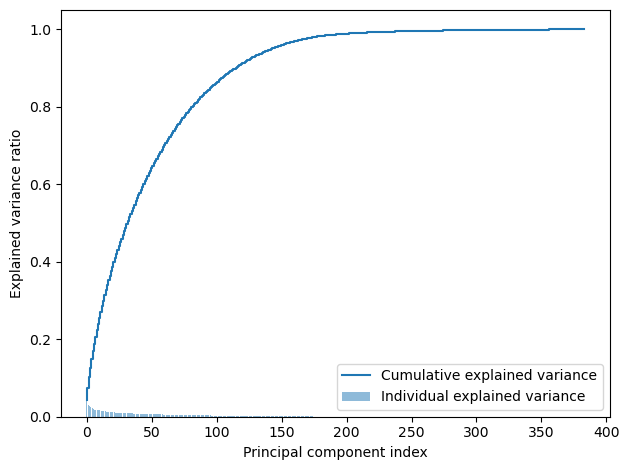

In [121]:
sentence_model = SentenceTransformer("multi-qa-MiniLM-L6-dot-v1")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(embeddings)
embeddings_std = sc.transform(embeddings)

from numpy.linalg import eigh
cov_matrix = np.cov(embeddings_std, rowvar=False)
egnvalues, egnvectors = eigh(cov_matrix)
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]

import matplotlib.pyplot as plt
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [118]:
embeddings.shape

(3804, 768)

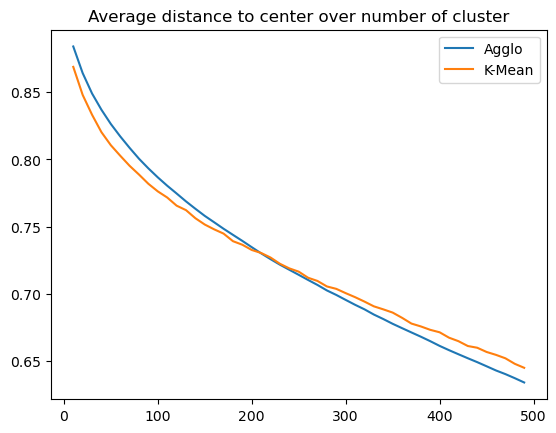

In [3]:
import numpy as np
from bertopic.dimensionality import BaseDimensionalityReduction
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.cluster import KMeans, AgglomerativeClustering

embedding_models = ["all-mpnet-base-v2"]

#Topic representation not tested yet

SEED = 100

np.random.seed(SEED)

sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

average_distances_for_each_try_agglo = []
average_distances_for_each_try_kmeans = []

for n_cluster in range(10, 500, 10):
    clustering_method = AgglomerativeClustering(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    topic_embeddings = topic_model.topic_embeddings_
    docs_embeddings = embeddings

    have_outliers = int(-1 in topics) #This will be 1 if there is an outlier topic, just to cope with how topic_model.topic_embeddings_ is

    topics = np.array(topics)
    valid_points_mask = (topics != -1)
    valid_points = docs_embeddings[valid_points_mask]
    valid_assignments = topics[valid_points_mask]
    # Calculate the distances for each valid point to its assigned cluster center
    distances = np.linalg.norm(valid_points - topic_embeddings[valid_assignments + have_outliers], axis=1)
    # Calculate the average distance for each cluster
    average_distances = np.zeros(len(topic_embeddings)-have_outliers)
    count_per_cluster = np.zeros(len(topic_embeddings)-have_outliers)
    for i in range(len(valid_assignments)):
        cluster_idx = valid_assignments[i]
        average_distances[cluster_idx] += distances[i]
        count_per_cluster[cluster_idx] += 1
    # Avoid division by zero
    count_per_cluster[count_per_cluster == 0] = 1
    average_distances /= count_per_cluster

    average_distances_for_each_try_agglo.append(np.average(distances))


for n_cluster in range(10, 500, 10):
    clustering_method = KMeans(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    topic_embeddings = topic_model.topic_embeddings_ #for every topic there is one vector
    docs_embeddings = embeddings

    have_outliers = int(-1 in topics) #This will be 1 if there is an outlier topic, just to cope with how topic_model.topic_embeddings_ is

    topics = np.array(topics)
    valid_points_mask = (topics != -1) #leaving -1 out
    valid_points = docs_embeddings[valid_points_mask]
    valid_assignments = topics[valid_points_mask]
    # Calculate the distances for each valid point to its assigned cluster center
    
    distances = np.linalg.norm(valid_points - topic_embeddings[valid_assignments + have_outliers], axis=1) 
    #Note: modify the distances vector for different metrices
    
    # Calculate the average distance for each cluster
    average_distances = np.zeros(len(topic_embeddings)-have_outliers)
    count_per_cluster = np.zeros(len(topic_embeddings)-have_outliers)
    for i in range(len(valid_assignments)):
        cluster_idx = valid_assignments[i]
        average_distances[cluster_idx] += distances[i]
        count_per_cluster[cluster_idx] += 1
    # Avoid division by zero
    count_per_cluster[count_per_cluster == 0] = 1
    average_distances /= count_per_cluster

    average_distances_for_each_try_kmeans.append(np.average(distances))


import matplotlib.pyplot as plt 

plt.plot(range(10, 500, 10), average_distances_for_each_try_agglo, label = "Agglo")
plt.plot(range(10, 500, 10), average_distances_for_each_try_kmeans, label = "K-Mean")
plt.title("Average distance to center over number of cluster") 
plt.legend()
plt.show()


kmean -  1610
kmean -  1620
kmean -  1630
kmean -  1640
kmean -  1650
kmean -  1660
kmean -  1670
kmean -  1680
kmean -  1690
kmean -  1700
kmean -  1710
kmean -  1720
kmean -  1730
kmean -  1740
kmean -  1750
kmean -  1760
kmean -  1770
kmean -  1780
kmean -  1790
kmean -  1800
kmean -  1810
kmean -  1820
kmean -  1830
kmean -  1840
kmean -  1850
kmean -  1860
kmean -  1870
kmean -  1880
kmean -  1890
kmean -  1900
kmean -  1910
kmean -  1920
kmean -  1930
kmean -  1940
kmean -  1950
kmean -  1960
kmean -  1970
kmean -  1980
kmean -  1990
kmean -  2000
kmean -  2010
kmean -  2020
kmean -  2030
kmean -  2040
kmean -  2050
kmean -  2060
kmean -  2070
kmean -  2080
kmean -  2090
kmean -  2100
kmean -  2110
kmean -  2120
kmean -  2130
kmean -  2140
kmean -  2150
kmean -  2160
kmean -  2170
kmean -  2180
kmean -  2190
kmean -  2200
kmean -  2210
kmean -  2220
kmean -  2230
kmean -  2240
kmean -  2250
kmean -  2260
kmean -  2270
kmean -  2280
kmean -  2290
kmean -  2300
kmean -  2310
kmean 

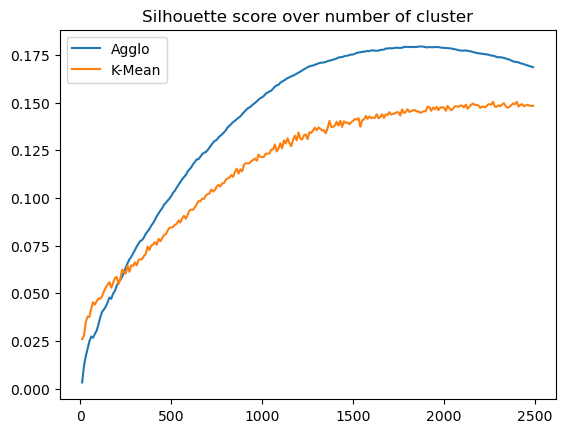

In [7]:
# import numpy as np
# from bertopic.dimensionality import BaseDimensionalityReduction
# from sentence_transformers import SentenceTransformer
# from bertopic import BERTopic
# from sklearn.cluster import KMeans, AgglomerativeClustering
# from sklearn.metrics import silhouette_score

# embedding_models = ["all-mpnet-base-v2"]

# #Topic representation not tested yet

# SEED = 100

# np.random.seed(SEED)

# sentence_model = SentenceTransformer("all-mpnet-base-v2")
# embeddings = sentence_model.encode(docs, show_progress_bar=False)

# silhouette_for_each_try_agglo = []
# silhouette_for_each_try_kmeans = []

# for n_cluster in range(10, 2500, 10):
#     clustering_method = AgglomerativeClustering(n_clusters=n_cluster)

#     topic_model = BERTopic(hdbscan_model=clustering_method,
#                            embedding_model=sentence_model,
#                            umap_model=BaseDimensionalityReduction())
#     topics, probs = topic_model.fit_transform(docs, embeddings)
#     topics = np.array(topics)
#     silhouette_for_each_try_agglo.append(silhouette_score(embeddings, topics))


for n_cluster in range(1610, 2500, 10):
    print("kmean - ", n_cluster)
    clustering_method = KMeans(n_clusters=n_cluster)

    topic_model = BERTopic(hdbscan_model=clustering_method,
                           embedding_model=sentence_model,
                           umap_model=BaseDimensionalityReduction())
    topics, probs = topic_model.fit_transform(docs, embeddings)
    topics = np.array(topics)
    silhouette_for_each_try_kmeans.append(silhouette_score(embeddings, topics))
    


import matplotlib.pyplot as plt 

plt.plot(range(10, 2500, 10), silhouette_for_each_try_agglo, label = "Agglo")
plt.plot(range(10, 2500, 10), silhouette_for_each_try_kmeans, label = "K-Mean")
plt.title("Silhouette score over number of cluster") 
plt.legend()
plt.show()


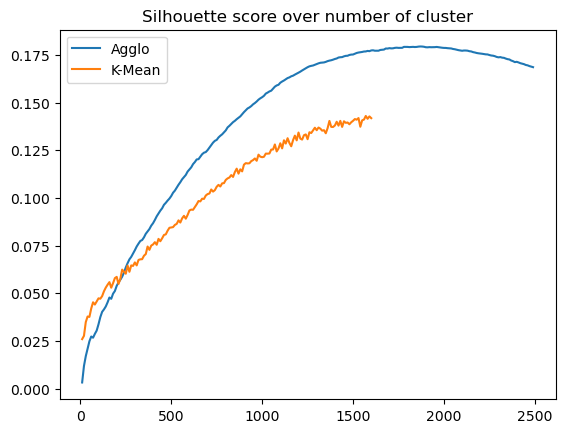

In [6]:
import matplotlib.pyplot as plt 

plt.plot(range(10, 2500, 10), silhouette_for_each_try_agglo, label = "Agglo")
plt.plot(range(10, 1610, 10), silhouette_for_each_try_kmeans, label = "K-Mean")
plt.title("Silhouette score over number of cluster") 
plt.legend()
plt.show()
